In [ ]:
# Uncomment line below to install exlib
# !pip install exlib

In [3]:
import sys
sys.path.append('/shared_data0/chaenyk/exlib/src')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import skimage

import exlib
from exlib.datasets.cholec import *
from exlib.features.vision import *

## Overview
* The objective is to predict the **go/nogo** regions (safe, unsafe).
* The higher-level features are the **organs** (liver, gallblader, and hepatocystic triangle).

## Load datasets and pre-trained models

In [4]:
dataset = CholecDataset(split="test")
gonogo_model = CholecModel.from_pretrained("BrachioLab/cholecystectomy_gonogo").eval()

config.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/runai-home/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100% 97.8M/97.8M [00:01<00:00, 102MB/s] 


model.safetensors:   0%|          | 0.00/132M [00:00<?, ?B/s]

## Dataset samples and model predictions
Primary task: predict the safe/unsafe regions

In [5]:
sample = dataset[7] # Lucky number
image, gonogo, organs = sample["image"], sample["gonogo"], sample["organs"]
with torch.no_grad():
    gonogo_pred = gonogo_model(image[None,...]).logits[0].argmax(dim=0)

<Figure size 640x480 with 0 Axes>

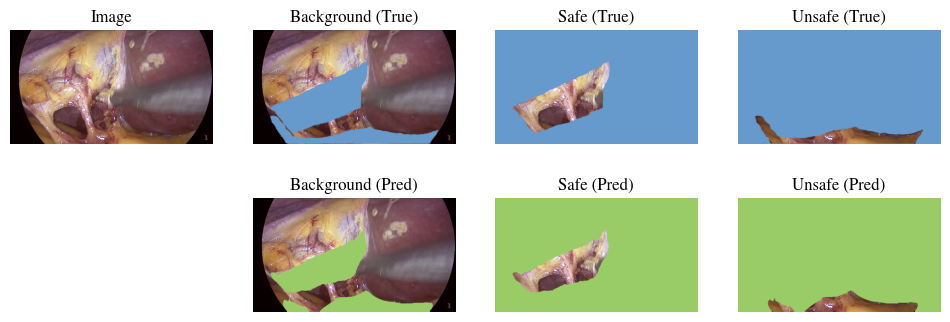

In [6]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    ["image", "gng_t0", "gng_t1", "gng_t2"],
    [".", "gng_p0", "gng_p1", "gng_p2"],
], figsize=(12,4))

for _, a in ax.items(): a.set_axis_off()
gng_titles = ["Background", "Safe", "Unsafe"]
C1 = torch.tensor([0.4, 0.6, 0.8]).view(3,1,1)
C2 = torch.tensor([0.6, 0.8, 0.4]).view(3,1,1)

ax["image"].imshow(image.numpy().transpose(1,2,0))
ax["image"].set_title("Image")

for i in range(3):
    mask_t = (gonogo == i).unsqueeze(0)
    mask_p = (gonogo_pred == i).unsqueeze(0)
    ax[f"gng_t{i}"].imshow(((image * mask_t) + (~mask_t * C1)).numpy().transpose(1,2,0))
    ax[f"gng_p{i}"].imshow(((image * mask_p) + (~mask_p * C2)).numpy().transpose(1,2,0))
    ax[f"gng_t{i}"].set_title(f"{gng_titles[i]} (True)")
    ax[f"gng_p{i}"].set_title(f"{gng_titles[i]} (Pred)")


## Expert-specified higher-level features: organs
Identifying key anatomical structures is an important step for surgeons

<Figure size 640x480 with 0 Axes>

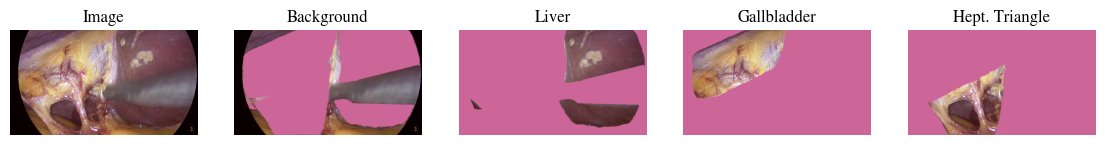

In [7]:
plt.clf()
fig, ax = plt.subplot_mosaic([
    ["image", "org_t0", "org_t1", "org_t2", "org_t3"],
], figsize=(14,4))

for _, a in ax.items(): a.set_axis_off()
org_titles = ["Background", "Liver", "Gallbladder", "Hept. Triangle"]
C3 = torch.tensor([0.8, 0.4, 0.6]).view(3,1,1)

ax["image"].imshow(image.numpy().transpose(1,2,0))
ax["image"].set_title("Image")

for i in range(4):
    mask_t = (organs == i).unsqueeze(0)
    ax[f"org_t{i}"].imshow(((image * mask_t) + (~mask_t * C3)).numpy().transpose(1,2,0))
    ax[f"org_t{i}"].set_title(f"{org_titles[i]}")

## How well are the higher-level feature alignments?
Let's define the following high-level feature extractors for comparison:
* gridding
* quickshift
* watershed

In [ ]:
scores = get_cholec_scores(dataset=dataset, N=100, batch_size=4)

 60% 15/25 [46:58<30:39, 183.92s/it] 